In [102]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.quantum_info import Statevector, state_fidelity

os.makedirs("results", exist_ok=True)


In [103]:
# Bell state |Φ+>
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
print(qc.draw())

# Ideal statevector (no noise)
ideal_state = Statevector.from_instruction(qc)
print("Ideal statevector length =", len(ideal_state))
print("Ideal fidelity with itself =", state_fidelity(ideal_state, ideal_state))


     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
Ideal statevector length = 4
Ideal fidelity with itself = 0.9999999999999996


In [104]:
def build_meas_circuit(qc):
    qc_m = qc.copy()
    qc_m.measure_all()
    return qc_m

qc_meas = build_meas_circuit(qc)
print("Measurement circuit:")
print(qc_meas.draw())

# Calibration circuits for 2 qubits in order ["00","01","10","11"]
cal_circs = []
cal_states = ["00","01","10","11"]
for bits in cal_states:
    c = QuantumCircuit(2)
    # note: bit order here is q0 q1 so apply X accordingly
    if bits[0] == "1": c.x(0)
    if bits[1] == "1": c.x(1)
    c.measure_all()
    cal_circs.append(c)
print("Number of calibration circuits:", len(cal_circs))


Measurement circuit:
        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 
Number of calibration circuits: 4


In [105]:
def noise_model_depolarizing(depol_prob=0.0, readout_error_prob=0.02):
    nm = NoiseModel()
    # depolarizing on 1q and 2q gates
    nm.add_all_qubit_quantum_error(depolarizing_error(depol_prob, 1), ["h"])
    nm.add_all_qubit_quantum_error(depolarizing_error(depol_prob, 2), ["cx"])

    # readout error: construct a 4x4 readout matrix for 2 qubits
    # small symmetric readout error -> flip probability readout_error_prob on each measured bit pair block
    p = float(readout_error_prob)
    # naive block-form: errors only swap 00<->01 and 10<->11 (simple model)
    # better: symmetric bit-flip on each qubit independently (use tensor product)
    # build 1-qubit readout matrix and tensor it
    r1 = np.array([[1-p, p],
                   [p, 1-p]])
    r2 = np.kron(r1, r1)  # 4x4
    nm.add_readout_error(ReadoutError(r2), [0,1])
    return nm


In [106]:
def get_cal_matrix(backend, cal_circs, shots_cal=4096):
    # run all calibrations
    job = backend.run(cal_circs, shots=shots_cal)
    res = job.result()
    probs = []
    for i, circ in enumerate(cal_circs):
        counts = res.get_counts(i)
        vec = np.zeros(4)
        for idx, st in enumerate(["00","01","10","11"]):
            vec[idx] = counts.get(st, 0) / shots_cal
        probs.append(vec)
    cal_mat = np.vstack(probs)   # shape (4,4) rows correspond to prepared states
    return cal_mat


In [107]:
def run_measurement_and_mitigate(backend, qc_meas, ideal_probs, cal_circs, nm,
                                shots=8192, shots_cal=4096, seed_sim=None):
    # 1) calibration matrix (rows sum should be ~1)
    cal_mat = get_cal_matrix(backend, cal_circs, shots_cal=shots_cal)

    # 2) run the measured circuit
    job = backend.run(qc_meas, shots=shots)
    res = job.result()
    counts = res.get_counts()
    noisy_vec = np.zeros(4)
    for i, st in enumerate(["00","01","10","11"]):
        noisy_vec[i] = counts.get(st, 0) / shots

    # 3) raw measurement fidelity (classical fidelity between distributions)
    raw_fid = float(np.dot(ideal_probs, noisy_vec))

    # 4) mitigation: invert calibration matrix (pseudo-inverse for stability)
    M_inv = np.linalg.pinv(cal_mat)
    mitigated = M_inv.dot(noisy_vec)
    mitigated = np.maximum(mitigated, 0)          # clip negative numerical noise
    if mitigated.sum() <= 0:
        mitigated = np.ones_like(mitigated)/len(mitigated)
    mitigated = mitigated / mitigated.sum()

    mit_fid = float(np.dot(ideal_probs, mitigated))
    return noisy_vec, mitigated, raw_fid, mit_fid, cal_mat


In [108]:
def run_statevector_noisy(backend, qc, noise_model=None, seed_sim=None):
    # Build a copy and request statevector (save_statevector)
    qc_sv = qc.copy()
    # For AerSimulator with method='statevector' and a noise_model, Aer will produce a noisy statevector (if supported).
    # Use backend configured with method 'statevector' and noise_model -> then get_statevector()
    job = backend.run(qc_sv)
    res = job.result()
    # try to access the statevector for the single experiment (index 0)
    try:
        sv = res.get_statevector(0)
    except Exception:
        # fallback: extract density matrix and convert to statevector fidelity by using density matrix
        dm = res.data(0).get('density_matrix', None)
        if dm is None:
            raise RuntimeError("No statevector or density matrix available in result.")
        # return density matrix (as numpy array) and indicate dm
        return dm
    return sv


In [109]:
# Config
base_depol = 0.01
scale_factors = [1.0, 2.0, 3.0]         # noise scaling factors
seeds = [101, 102, 103]                 # seeds (use small set for quick runs)
shots = 4096
shots_cal = 4096

rows = []
rows_state = []

for scale in scale_factors:
    dep = base_depol * scale
    nm = noise_model_depolarizing(depol_prob=dep, readout_error_prob=0.02)
    print("\n--- scale", scale, "dep=", dep)

    # Setup simulator with noise model and a seed for reproducibility
    backend_meas = AerSimulator(seed_simulator=123, noise_model=nm)
    # Configure for density_matrix to handle mixed states from noise
    backend_sv = AerSimulator(method='density_matrix', seed_simulator=123, noise_model=nm)

    raw_fids = []
    mit_fids = []
    # state fidelities (one per seed)
    sv_fids = []

    for s in seeds:
        # measurement-based run
        noisy_vec, mitigated_vec, raw_fid, mit_fid, cal_mat = run_measurement_and_mitigate(
            backend_meas, qc_meas, np.array([0.5,0,0,0.5]), cal_circs, nm,
            shots=shots, shots_cal=shots_cal, seed_sim=s)
        raw_fids.append(raw_fid)
        mit_fids.append(mit_fid)

        # statevector/density fidelity run
        # use a backend configured to return statevector/density
        # Configure for density_matrix for local simulator as well
        backend_sv_local = AerSimulator(method='density_matrix', seed_simulator=s, noise_model=nm)

        # Create a copy of qc and explicitly add a save_density_matrix instruction
        qc_with_save = qc.copy()
        qc_with_save.save_density_matrix() # Explicitly save the density matrix

        job = backend_sv_local.run(qc_with_save)   # run the circuit (no measurement)
        res = job.result()

        # Directly get the density matrix from data(0) as res.get_density_matrix(0) failed unexpectedly
        dm = res.data(0).get('density_matrix', None)
        if dm is None:
            raise RuntimeError("No density matrix available in result. Simulator did not produce it.")

        from qiskit.quantum_info import DensityMatrix
        dm_obj = DensityMatrix(dm)
        f_sv = float(state_fidelity(ideal_state, dm_obj))

        sv_fids.append(f_sv)

    rows.append({
        "scale": scale,
        "depol_prob": dep,
        "raw_fidelity_mean": float(np.mean(raw_fids)),
        "raw_fidelity_std": float(np.std(raw_fids)),
        "mitigated_fidelity_mean": float(np.mean(mit_fids)),
        "mitigated_fidelity_std": float(np.std(mit_fids)),
        "num_seeds": len(seeds)
    })
    rows_state.append({
        "scale": scale,
        "depol_prob": dep,
        "state_fidelity_mean": float(np.mean(sv_fids)),
        "state_fidelity_std": float(np.std(sv_fids)),
        "num_seeds": len(seeds)
    })

df_meas = pd.DataFrame(rows)
df_sv = pd.DataFrame(rows_state)
df_meas.to_csv("results/exp3_measurement_zne_summary.csv", index=False)
df_sv.to_csv("results/exp3_statevector_zne_summary.csv", index=False)

print("\nMeasurement table:")
print(df_meas)
print("\nStatevector table:")
print(df_sv)


--- scale 1.0 dep= 0.01

--- scale 2.0 dep= 0.02

--- scale 3.0 dep= 0.03

Measurement table:
   scale  depol_prob  raw_fidelity_mean  raw_fidelity_std  \
0    1.0        0.01           0.497559               0.0   
1    2.0        0.02           0.495117               0.0   
2    3.0        0.03           0.492676               0.0   

   mitigated_fidelity_mean  mitigated_fidelity_std  num_seeds  
0                 0.497559                     0.0          3  
1                 0.495117                     0.0          3  
2                 0.492676                     0.0          3  

Statevector table:
   scale  depol_prob  state_fidelity_mean  state_fidelity_std  num_seeds
0    1.0        0.01              0.98755        1.110223e-16          3
1    2.0        0.02              0.97520        1.110223e-16          3
2    3.0        0.03              0.96295        1.110223e-16          3


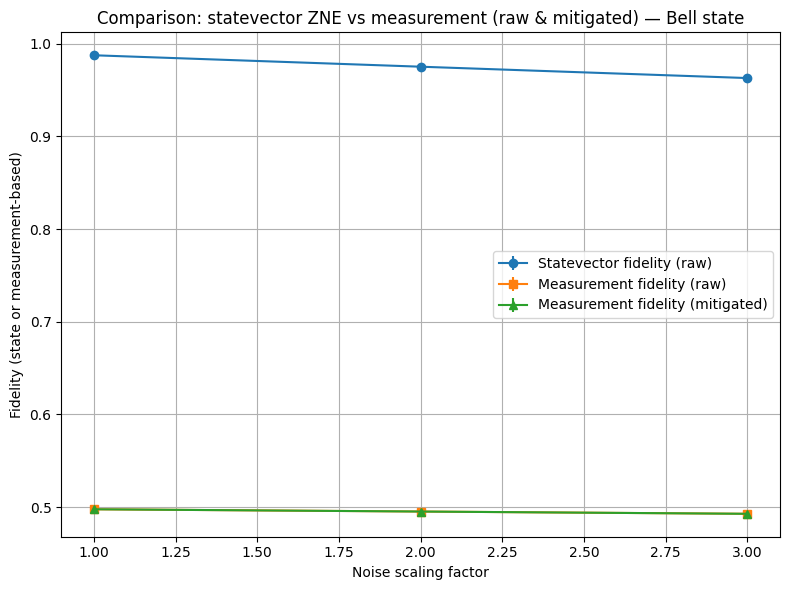

In [110]:
plt.figure(figsize=(8,6))
plt.errorbar(df_sv["scale"], df_sv["state_fidelity_mean"], yerr=df_sv["state_fidelity_std"],
             marker='o', label="Statevector fidelity (raw)")
plt.errorbar(df_meas["scale"], df_meas["raw_fidelity_mean"], yerr=df_meas["raw_fidelity_std"],
             marker='s', label="Measurement fidelity (raw)")
plt.errorbar(df_meas["scale"], df_meas["mitigated_fidelity_mean"], yerr=df_meas["mitigated_fidelity_std"],
             marker='^', label="Measurement fidelity (mitigated)")

plt.title("Comparison: statevector ZNE vs measurement (raw & mitigated) — Bell state")
plt.xlabel("Noise scaling factor")
plt.ylabel("Fidelity (state or measurement-based)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/exp3_comparison_plot.png", dpi=200)
plt.show()

